# Cepheids: Metallicity Analysis

- Gabriel Wendell Celestino Rocha
- Leonardo Andrade de Almeida

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.collections import PolyCollection, LineCollection

from loguru import logger
import statsmodels.api as sm
from scipy.stats import linregress
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic Functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20


###############
# SINGLE PLOT #
###############
def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)
        
        
# ----------------------------------------------------------------------------------------------------------


###############
## PLOT AXES ##
###############
def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)

---

## 1. Loading data

The data tables were extracted from the article itself and saved in `data` folder.

The master dataframe consists of the union of the two datasets presented above. It is also important to reorganize the data so that it is indexed based on the galaxy analyzed (NGC number). The base-$10\log$ of the period for each Cepheid is also calculated.

In [3]:
data_path = 'data/'
df_path = data_path + 'R11treat.dat'

df = pd.read_csv(df_path, sep = '	', skiprows = 8)
print('DATAFRAME MASTER =D')
display(df)

print('---------------------')
print('  SHAPE =', df.shape)
print('---------------------')

info_path = data_path + 'R11treat_info.txt'

with open(info_path, 'r') as file:
    info = file.read()

print(info)

DATAFRAME MASTER =D


,id,gal,z,dL,M,Merr,m,merr,P,logP,logO_H,bias,Pivot
0,27185,4536,0.006031,25.847143,-7.549763,0.31,24.5123,0.31,13.000,1.113943,-3.46,0.13,1.474125
1,42353,4536,0.006031,25.847143,-6.071363,0.74,25.9907,0.74,13.070,1.116276,-3.03,0.37,1.474125
2,50718,4536,0.006031,25.847143,-7.912863,0.42,24.1492,0.42,13.730,1.137671,-3.36,0.28,1.474125
3,72331,4536,0.006031,25.847143,-7.586963,0.44,24.4751,0.44,13.910,1.143327,-3.19,0.22,1.474125
4,65694,4536,0.006031,25.847143,-7.203863,0.38,24.8582,0.38,14.380,1.157759,-3.10,0.39,1.474125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,29163,4258,0.001494,6.402857,-4.879869,0.57,24.1520,0.57,6.739,0.828595,-3.25,0.38,1.474125
642,34729,4258,0.001494,6.402857,-6.371069,0.50,22.6608,0.50,14.920,1.173769,-3.25,0.00,1.474125
643,89375,4258,0.001494,6.402857,-6.619069,0.45,22.4128,0.45,12.380,1.092721,-3.11,0.42,1.474125
644,246695,4258,0.001494,6.402857,-6.434969,0.40,22.5969,0.40,11.200,1.049218,-3.11,0.49,1.474125


---------------------
  SHAPE = (646, 13)
---------------------

# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#      id: the ID of the cepheid
#     gal: the NGC number of the host galaxy
#       z: redshift of the host galaxy
#      dL: the distance computed via Hubble's law
#       M: abs mags M are computed using M = m + 5*log10(dL/Mpc) + 25
#    Merr: abs mags errs are just the mags m errs
#       m: mags m are computed using m = F160W - 0.41*(V_I)
#    merr: mag errs are just those in the F160W mags
#          (errors in V-I were not given in R11)
#       P: period P is in days (errors in the Period were not given)
#    logP: base-10log of the period for each Cepheid
#  logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#    bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag err

---

## 2. Linear Fit and Residual Analysis

In [4]:
# Define the dependent and independent variables
X = df['logP']  # Independent variable
y = df['M']     # Dependent variable

# Add a constant (intercept) to the independent variable
X = sm.add_constant(X)

# Perform OLS regression
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     705.3
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          1.59e-105
Time:                        18:24:33   Log-Likelihood:                -788.74
No. Observations:                 646   AIC:                             1581.
Df Residuals:                     644   BIC:                             1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6826      0.176    -15.239      0.0

In [11]:
a = model.params['logP']                 # Slope
b = model.params['const']                # Intercept
std_err_a = model.bse['logP']            # Standard error of the slope
std_err_b = model.bse['const']           # Standard error of the intercept
confidence_intervals = model.conf_int()  # Confidence Intervals

print(f"Slope (a): {a}, \nIntercept (b): {b}")
print(f"\n\nStandard error of slope (a): {std_err_a}, \nStandard error of intercept (b): {std_err_b}")
print("\n\nConfidence Intervals:\n", confidence_intervals)

Slope (a): -3.11748848959179, 
Intercept (b): -2.6825523078758415


Standard error of slope (a): 0.11738523313974678, 
Standard error of intercept (b): 0.1760344604089304


Confidence Intervals:
               0         1
const -3.028223 -2.336881
logP  -3.347993 -2.886984


In [34]:
logP = df['logP']
M = df['M']
err_M = df['Merr']
logO_H = df['logO_H']

logP_range = np.linspace(min(logP), max(logP), 100)
M_fit_upper = (a + std_err_a) + (b + std_err_b) * logP_range
M_fit_lower = (a - std_err_a) + (b - std_err_b) * logP_range

In [42]:
# Predicted values
df['M_pred'] = model.predict(X)

# Residuals
df['Res'] = df['M'] - df['M_pred']

n = len(df)
# Number of predictors
p = 1  # Only 'logP' is the predictor in this case
ss_res = np.sum(df['Res'] ** 2)
rse = np.sqrt(ss_res / (n - p - 1))

print(f"Residual Standard Error (RSE): {rse}")

Residual Standard Error (RSE): 0.82166549235089


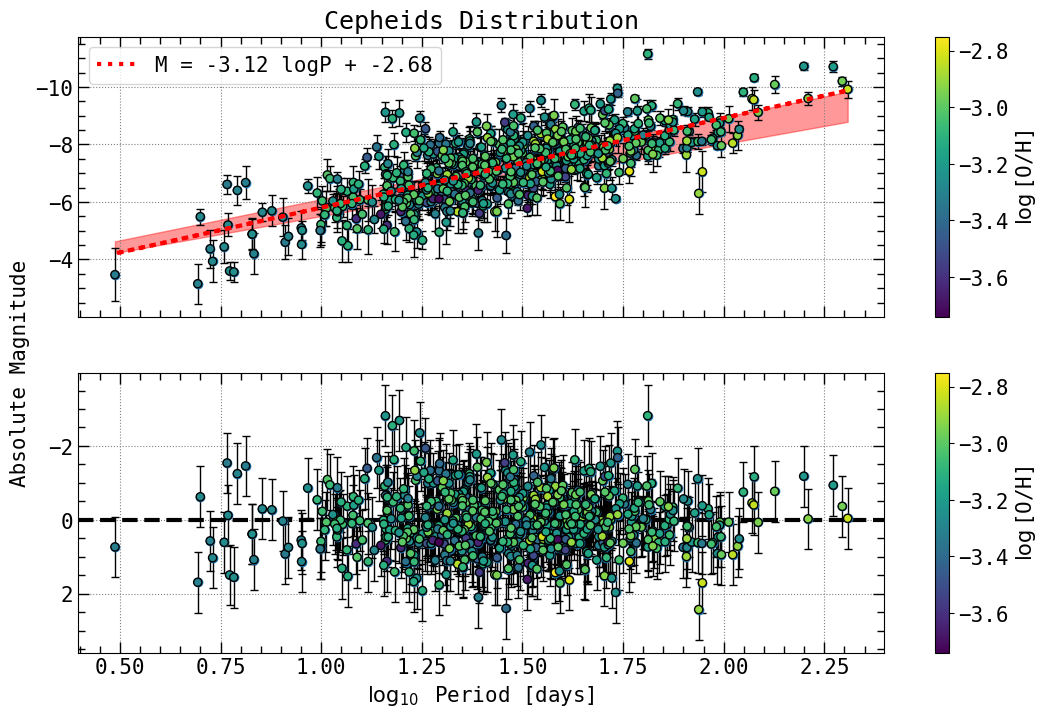

In [128]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize = (13,8), sharex = True)

sc1 = axs[0].scatter(df['logP'], df['M'], c = df['logO_H'], cmap = 'viridis', s = 35, edgecolor = 'k', zorder = 3)
axs[0].errorbar(df['logP'], df['M'], yerr = df['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)
axs[0].plot(df['logP'], df['M_pred'], color = 'r', ls = ':', lw = 3, zorder = 4, 
           label = 'M = {:.2f} logP + {:.2f}'.format(a, b))

# Confidence intervals
axs[0].fill_between(logP_range, M_fit_lower, M_fit_upper, color = 'r', alpha = 0.4)


sc2 = axs[1].scatter(df['logP'], df['Res'], c = df['logO_H'], cmap = 'viridis', s = 35, edgecolor = 'k', zorder = 3)
axs[1].axhline(0, color = 'black', ls = '--', lw = 3)
axs[1].errorbar(df['logP'], df['Res'], yerr = rse, fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)

cbar1 = fig.colorbar(sc1)
cbar2 = fig.colorbar(sc2)
cbar1.set_label(r'$\log$[O/H]')
cbar2.set_label(r'$\log$[O/H]')

axs[1].set_xlabel(r'$\log_{10}$ Period [days]')
axs[0].set_ylabel('Absolute Magnitude', y = -0.2)
axs[0].set_title('Cepheids Distribution')

axs[0].invert_yaxis()
axs[1].invert_yaxis()  
axs[0].legend(loc = 'best')
sm_plot_mod(axs[0])
sm_plot_mod(axs[1])

plt.savefig('Plots/logO_H-Fit+Res.png', dpi = 400)

## Multiple Linear Regression

In [112]:
# Add a constant term for the intercept in the regression model
X1 = sm.add_constant(pd.DataFrame({'logP': logP, 'log_OH': logO_H}))

# Fit the multiple linear regression model (M = beta_0 + beta_1 * logP + beta_2 * log[O/H])
model1 = sm.OLS(M, X1).fit()

# Print the summary of the regression results
print("Simple Multiple Linear Regression Results:")
print(model1.summary())

# Predicting the values
predictions1 = model1.predict(X1)

Simple Multiple Linear Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     352.2
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          5.03e-104
Time:                        22:12:15   Log-Likelihood:                -788.69
No. Observations:                 646   AIC:                             1583.
Df Residuals:                     643   BIC:                             1597.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

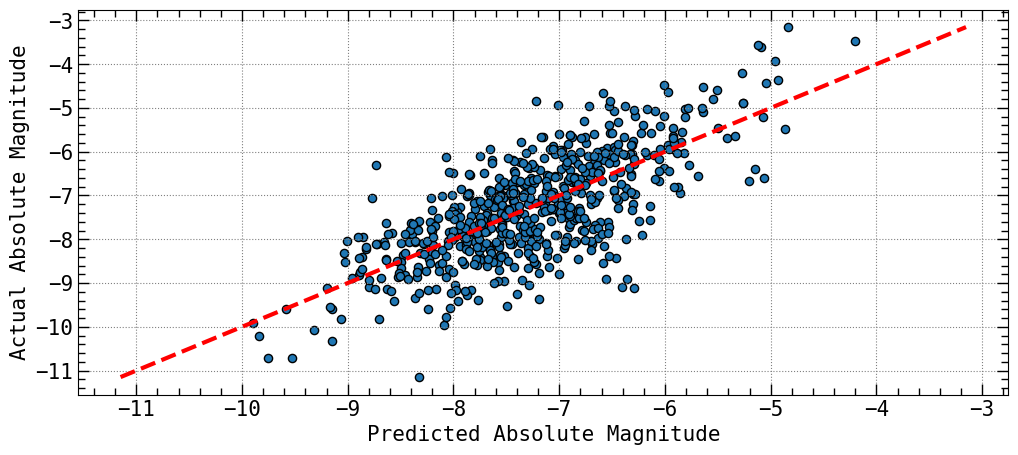

In [118]:
plt.figure(figsize = (12, 5))

plt.scatter(predictions1, M, s = 35, edgecolor = 'k', zorder = 1)
plt.plot([min(M), max(M)], [min(M), max(M)], color = 'r', ls = '--', lw = 3, zorder = 2)

plt.xlabel('Predicted Absolute Magnitude')
plt.ylabel('Actual Absolute Magnitude')

#plt.invert_yaxis()  
sm_plot()

In [122]:
# Create interaction term for the second model
interaction_term = logP * logO_H
X2 = sm.add_constant(pd.DataFrame({'logP': logP, 'logO_H': logO_H, 'Interaction': interaction_term}))

# Fit the multiple linear regression model with interaction term 
# (M = beta_0 + beta_1 * logP + beta_2 * log[O/H] + beta_3 * (logP * log[O/H]))
model2 = sm.OLS(M, X2).fit()

# Print the summary of the regression results
print("\nMultiple Linear Regression with Interaction Term Results:")
print(model2.summary())

# Predicting the values for the model with interaction term
predictions2 = model2.predict(X2)


Multiple Linear Regression with Interaction Term Results:
                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     236.5
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          2.43e-103
Time:                        22:18:34   Log-Likelihood:                -787.20
No. Observations:                 646   AIC:                             1582.
Df Residuals:                     642   BIC:                             1600.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

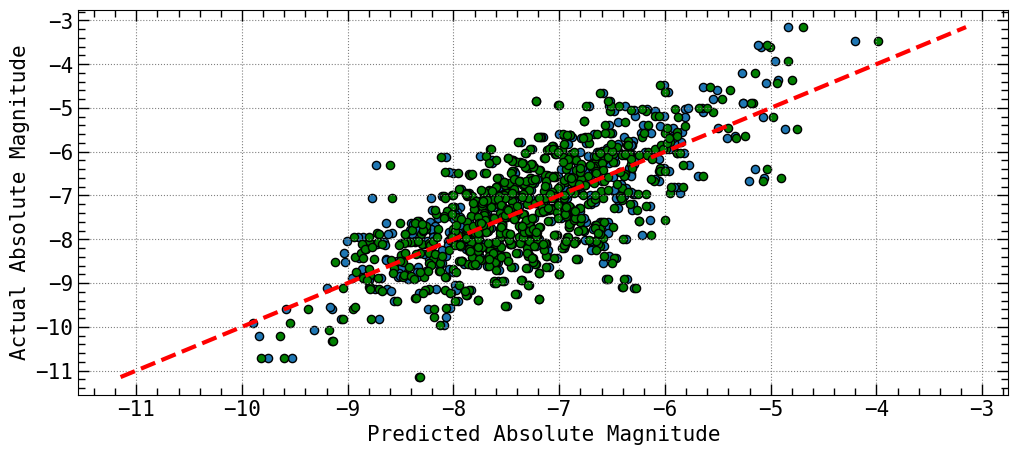

In [126]:
plt.figure(figsize = (12, 5))

plt.scatter(predictions1, M, s = 35, edgecolor = 'k', zorder = 1)
plt.scatter(predictions2, M, c = 'green', s = 35, edgecolor = 'k', zorder = 1)
plt.plot([min(M), max(M)], [min(M), max(M)], color = 'r', ls = '--', lw = 3, zorder = 2)

plt.xlabel('Predicted Absolute Magnitude')
plt.ylabel('Actual Absolute Magnitude')

#plt.invert_yaxis()  
sm_plot()